![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 22kB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 3.9MB 52.4MB/s 
     |████████████████████████████████| 450kB 52.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=933d6f1fb97f170a46c1afb343560dbbdf60248b2892b2e5e01f4449ced8bd80
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
import tensorflow
tensorflow.__version__


'2.1.0'

In [ ]:

# Setting the current working directory
import os; os.chdir('drive/My Drive/AIML/LAB')

In [ ]:
# Imports
import pandas as pd, matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# Create features and labels
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
# to define loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [ ]:
project_path = '/content/drive/My Drive/AIML/LAB/'

data = np.load(project_path + 'images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

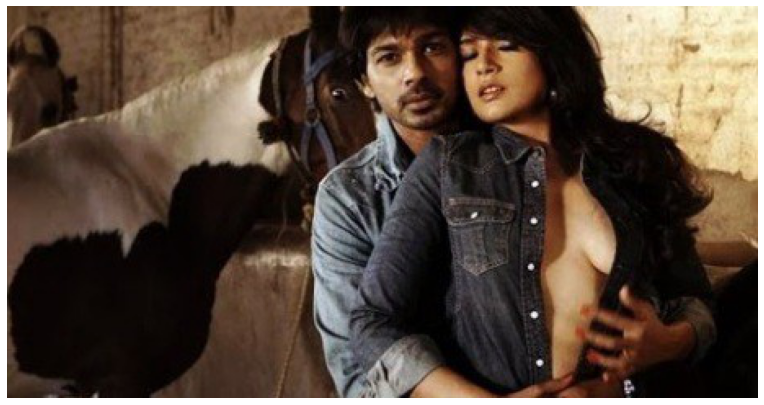

In [ ]:

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[2][0])
plt.show()

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [ ]:
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [ ]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
X.shape

(409, 224, 224, 3)

In [ ]:

masks.shape

(409, 224, 224)


# Print  a sample image after resizing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


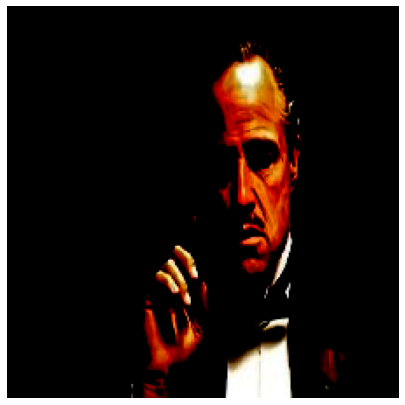

In [ ]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

Training data

In [ ]:
X_train =X[0:400]
y_train =masks[0:400]

In [ ]:
X_train.shape

(400, 224, 224, 3)

In [ ]:
y_train.shape

(400, 224, 224)

In [ ]:
X_test=X[400:409]
y_test=masks[400:409]

In [ ]:
X_test.shape

(9, 224, 224, 3)

In [ ]:
y_test.shape

(9, 224, 224)

### Print a sample training image, image array and its mask (2 marks)

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


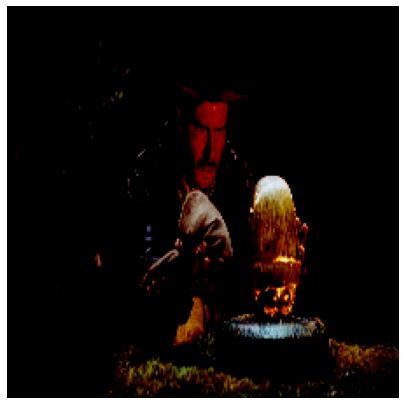

In [ ]:
n = 7
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X_train[n])

# Print the mask

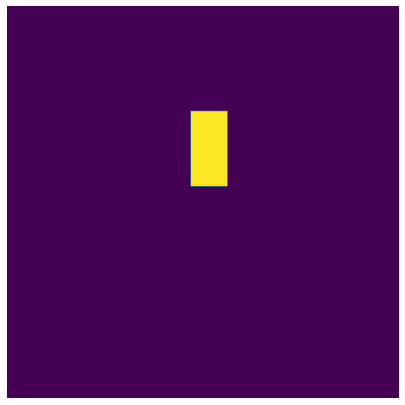

In [ ]:
n = 7
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(y_train[n])

## Create the model (5 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [ ]:
pip install segmentation_models

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D,Dense,BatchNormalization
from tensorflow.keras.models import Model,Sequential
import segmentation_models
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model # to join the two models

  

Segmentation Models: using `tf.keras` framework.


# FIRST METHOD

In [ ]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output

    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)
    
    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

**Call the create_model function (1 mark)**

Give trainable=False as argument, if you want to freeze lower layers for fast  training (but low accuracy)

In [ ]:

model2 = create_model(False)
model2.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

# **Define dice coefficient function (2 marks)**



In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

# Define loss function (2 marks)





In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

# Compile the model (2 marks)
Complie the model using below parameters

loss: use the loss function defined above

optimizers: use Adam optimizer

metrics: use dice_coefficient function defined above


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

# Define callbacks (2 marks)
Use ModelCheckpoint

Use EarlyStopping

Use ReduceLROnPlateau


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Fit the model (2 marks)
Fit the model using below parameters:

epochs: you can decide

batch_size: 1

callbacks: use the callbacks defined above

In [ ]:
model2.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Train on 400 samples, validate on 9 samples
Epoch 1/30
399/400 [============================>.] - ETA: 0s - loss: 1.5436 - dice_coefficient: 0.3827
Epoch 00001: val_loss improved from inf to 1.57320, saving model to model-1.57.h5
400/400 [==============================] - 25s 62ms/sample - loss: 1.5417 - dice_coefficient: 0.3831 - val_loss: 1.5732 - val_dice_coefficient: 0.3858
Epoch 2/30
399/400 [============================>.] - ETA: 0s - loss: 1.0968 - dice_coefficient: 0.4893
Epoch 00002: val_loss improved from 1.57320 to 1.03311, saving model to model-1.03.h5
400/400 [==============================] - 15s 38ms/sample - loss: 1.0956 - dice_coefficient: 0.4895 - val_loss: 1.0331 - val_dice_coefficient: 0.4740
Epoch 3/30
399/400 [============================>.] - ETA: 0s - loss: 0.8539 - dice_coefficient: 0.5711
Epoch 00003: val_loss did not improve from 1.03311
400/400 [==============================] - 14s 36ms/sample - loss: 0.8555 - dice_coefficient: 0.5703 - val_loss: 1.0435 - v

In [ ]:
model2.evaluate(X_test, y_test, verbose = 1)

9/9 [==============================] - 2s 186ms/sample - loss: 0.6816 - dice_coefficient: 0.6753


[0.6816210150718689, 0.6752624]

In [ ]:

# Load previous model weight
#WEIGHTS_FILE = "model_.435"
#learned_model = create_model()
#learned_model.load_weights(WEIGHTS_FILE)
y_pred = model2.predict(X_test, verbose = 1)

9/9 [==============================] - 1s 59ms/sample


Got a dice coefficient of around .66 and loss of around .72 on validation data.

## Get the predicted mask for a test image (2 marks)

# **Show the test image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


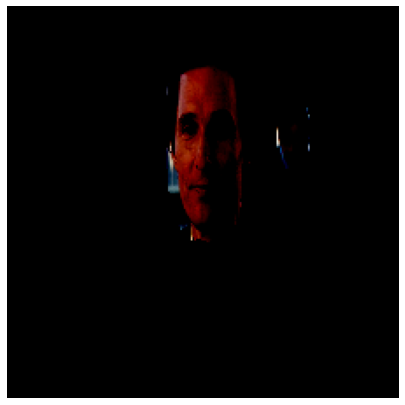

In [ ]:
# For a sample image
n = 3
image = cv2.resize(X_test[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

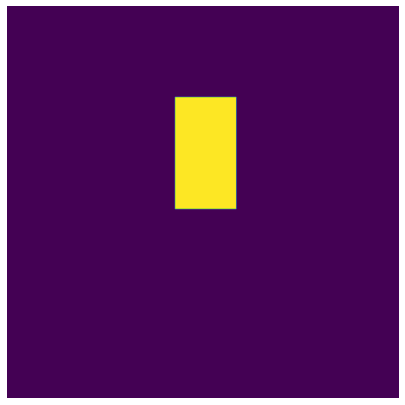

In [ ]:
n = 3
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(y_test[n],alpha=1)

Predict the mask on the test image




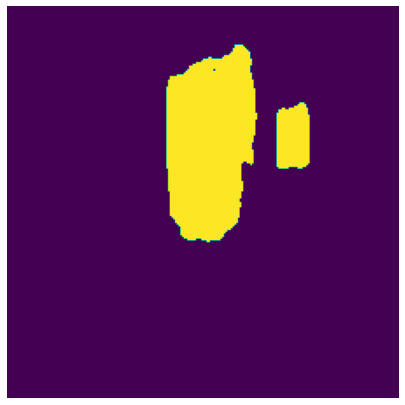

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

### Impose the mask on the test image (2 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


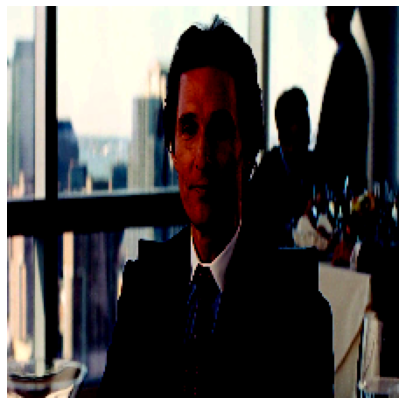

In [ ]:

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_test[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

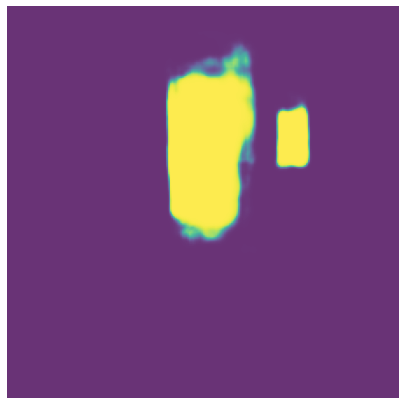

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

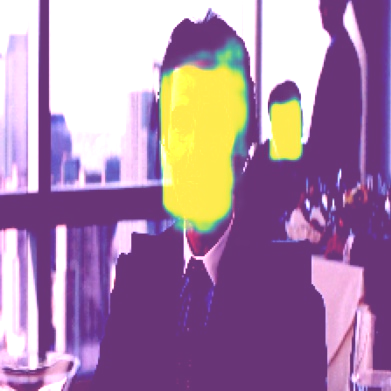

In [ ]:

from google.colab.patches import cv2_imshow
img = cv2.imread('image.jpg', 1)
mask = cv2.imread('mask.jpg', 1)
img = cv2.add(img, mask)
cv2_imshow(img)

# SECOND METHOD

In [ ]:
def create_model2(trainable=True):
    mobnet = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in mobnet.layers:
        layer.trainable = trainable

    block1 = mobnet.get_layer("conv_pw_5_relu").output
    block2 = mobnet.get_layer("conv_pw_11_relu").output
    block3 = mobnet.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = UpSampling2D()(x)
    x = UpSampling2D()(x)
    x = UpSampling2D()(x)
    
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)

    return Model(inputs=mobnet.input, outputs=x)  

In [ ]:
model = create_model2(False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
model.compile(loss = loss, optimizer = optimizer, metrics = [dice_coefficient])
model.fit(X_train, y_train, epochs = 30, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Train on 400 samples, validate on 9 samples
Epoch 1/30
396/400 [============================>.] - ETA: 0s - loss: 2.0314 - dice_coefficient: 0.2556
Epoch 00001: val_loss did not improve from 0.68111
400/400 [==============================] - 5s 12ms/sample - loss: 2.0299 - dice_coefficient: 0.2562 - val_loss: 1.9972 - val_dice_coefficient: 0.2534
Epoch 2/30
394/400 [============================>.] - ETA: 0s - loss: 1.6740 - dice_coefficient: 0.3193
Epoch 00002: val_loss did not improve from 0.68111
400/400 [==============================] - 3s 8ms/sample - loss: 1.6742 - dice_coefficient: 0.3193 - val_loss: 1.7673 - val_dice_coefficient: 0.2875
Epoch 3/30
395/400 [============================>.] - ETA: 0s - loss: 1.5384 - dice_coefficient: 0.3501
Epoch 00003: val_loss did not improve from 0.68111
400/400 [==============================] - 3s 8ms/sample - loss: 1.5422 - dice_coefficient: 0.3499 - val_loss: 1.6367 - val_dice_coefficient: 0.3121
Epoch 4/30
394/400 [=======================

In [ ]:
model.evaluate(X_test, y_test, verbose = 1)

9/9 [==============================] - 0s 50ms/sample - loss: 0.9238 - dice_coefficient: 0.5196


[0.9238417148590088, 0.5196113]

Got a Dice coefficent of .51 and loss of .92.Seems its an overfit model.

In [ ]:
y_preda = model.predict(X_test, verbose = 1)

9/9 [==============================] - 0s 39ms/sample


In [ ]:
n = 3
image = cv2.resize(X_test[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_maska = cv2.resize(1.0*(y_preda[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


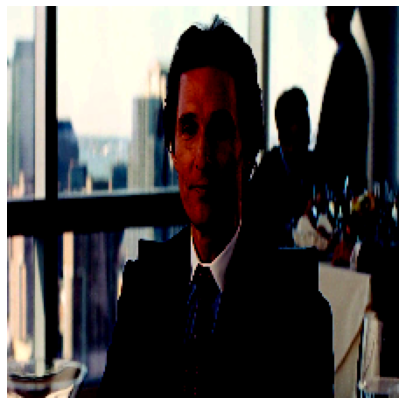

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_test[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

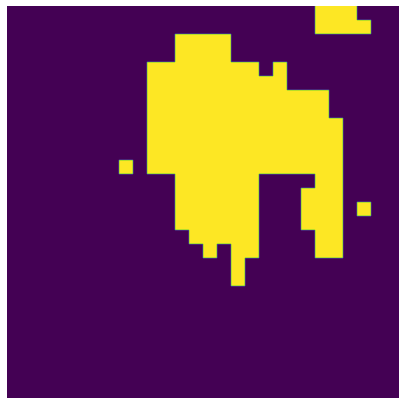

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_maska, alpha = 1)
plt.savefig('pred_maska.jpg', bbox_inches = 'tight', pad_inches = 0)

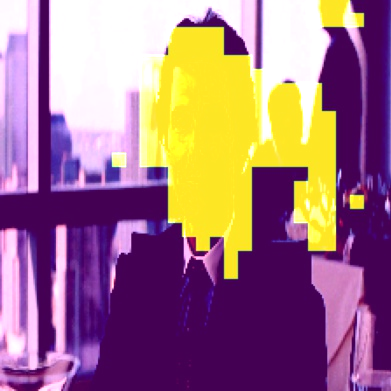

In [ ]:
img = cv2.imread('image.jpg', 1)
pre_mask = cv2.imread('pred_maska.jpg', 1)
img = cv2.add(img, pre_mask)
cv2_imshow(img)

# THIRD METHOD
**U NET BACKBONE**

In [ ]:
from segmentation_models import Unet # no softmax  
from segmentation_models.backbones.backbones_factory import Backbones


In [ ]:
#BACKBONE = 'mobilenetv2'
BACKBONE = 'resnet34'
preprocess_input = Backbones.get_preprocessing(BACKBONE)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 224, 224, 3), (400, 224, 224), (9, 224, 224, 3), (9, 224, 224))

In [ ]:
preprocess_input


<function classification_models.models.resnet.preprocess_input>

In [ ]:
x_train_u = preprocess_input(X_train) # X_train is my image, but x_train -- trasnformed features from transfer learning
# and this should be the input to my model
x_test_u = preprocess_input(X_test)

In [ ]:
base_model_unet = Unet(BACKBONE, encoder_weights='imagenet')

inp = Input(shape=(224, 224, 3))
l1 = Conv2D(3, (1, 1))(inp) # before we feed in to the base model # map N channels data to 3 channels #UNET + incep + imagenet -- how many channels in the output layer? I need 3 channels

out = base_model_unet(l1) #l1 is the joining layer between base model and my model

#l2 = Conv2D(3, (1, 1))(out) # to ensure I have the RGB
x1 = Conv2D(1, kernel_size =3,strides=1,padding = "same", activation="relu")(out)
#x1 = BatchNormalization()
#x4 = Conv2D(1, kernel_size=2,strides=2,padding = "same", activation="relu")(x1)
#x_out = Reshape((56,56))(x4)
x7 = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x1)
unet_model = Model(inp, x7, name=base_model_unet.name) #Model(I = input layer, O = output after the base model, name = 'xxx')

85524480/85521592 [==============================] - 1s 0us/step


In [ ]:
unet_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 3)       12        
_________________________________________________________________
model_3 (Model)              multiple                  24456154  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 1)       10        
_________________________________________________________________
reshape_2 (Reshape)          (None, 224, 224)          0         
Total params: 24,456,176
Trainable params: 24,438,826
Non-trainable params: 17,350
_________________________________________________________________


In [ ]:
base_model_unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    multiple             9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  multiple             0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  multiple             9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [ ]:
unet_model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
unet_model.fit(x_train_u, y_train, epochs = 50, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (x_test_u, y_test))

Train on 400 samples, validate on 9 samples
Epoch 1/50
399/400 [============================>.] - ETA: 0s - loss: 1.8291 - dice_coefficient: 0.2893
Epoch 00001: val_loss did not improve from 0.68111
400/400 [==============================] - 30s 75ms/sample - loss: 1.8268 - dice_coefficient: 0.2899 - val_loss: 2.9481 - val_dice_coefficient: 0.0841
Epoch 2/50
399/400 [============================>.] - ETA: 0s - loss: 1.3415 - dice_coefficient: 0.3919
Epoch 00002: val_loss did not improve from 0.68111
400/400 [==============================] - 24s 60ms/sample - loss: 1.3399 - dice_coefficient: 0.3924 - val_loss: 1.8062 - val_dice_coefficient: 0.2499
Epoch 3/50
399/400 [============================>.] - ETA: 0s - loss: 1.0430 - dice_coefficient: 0.4859
Epoch 00003: val_loss did not improve from 0.68111
400/400 [==============================] - 24s 61ms/sample - loss: 1.0421 - dice_coefficient: 0.4865 - val_loss: 1.4285 - val_dice_coefficient: 0.3506
Epoch 4/50
399/400 [==================

In [ ]:
unet_model.evaluate(X_test, y_test, verbose = 1)

9/9 [==============================] - 1s 140ms/sample - loss: 0.9821 - dice_coefficient: 0.5810


[0.9820972681045532, 0.5810433]

In [ ]:
y_pred_unet = unet_model.predict(X_test, verbose = 1)

 Got a dice coefficent of .58 and loss of .98.This model also seems to be an overfit model.

In [ ]:
image = cv2.resize(X_test[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0*(y_pred_unet[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

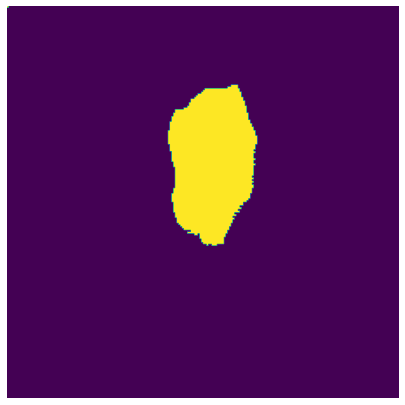

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)
plt.savefig('pred_mask.jpg', bbox_inches = 'tight', pad_inches = 0)

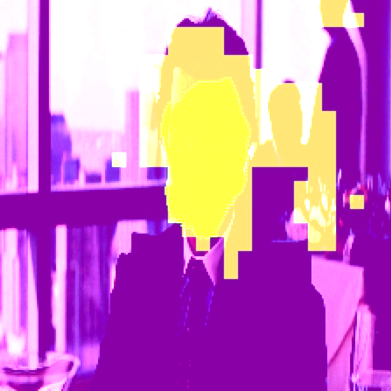

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
mg = cv2.imread('image.jpg', 1)
pre_mask = cv2.imread('pred_mask.jpg', 1)
img = cv2.add(img, pre_mask)
cv2_imshow(img)


# Conclusion
Project was all about how we can make use of a pretrained MobileNet (Transfer Learning) and on top of it add all the UNET layers to train, fit and evaluate model with an objective to predict the boundaries(mask) around the face in a given image.

Model was complied using binary cross entropy as loss, adam optimizer and dice coefficient as metrics.

Model checkpoint, early stopping and learning rate reducers were used as callbacks.

Data was split into train and validation using/  ratio. Best loss I got is 0. and dice coeff of 0.97 on the training data and .65 on testing data.

Model weights for this were used and then used to predict on validation data to get mask.

Further checked on sample image and imposed mask on the image.

As seen in the above images, it can be seen that First model does a very good job in predicting the masks.